In [11]:
# p.142 차영상으로 도면의 차이 찾아내기
import numpy as np
import cv2

# 이미지 그레이스케일로 변환
img1 = cv2.imread('./img/robot_arm1.jpg')
img2 = cv2.imread('./img/robot_arm2.jpg')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 두영상의 절대값 차 연산
diff = cv2.absdiff(img1_gray, img2_gray)

# 차영상을 극대화 위해 스레시홀드 처리 및 컬러 변환
_, diff = cv2.threshold(diff, 1, 255, cv2.THRESH_BINARY)
diff_red = cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)
diff_red[:, :, 2] = 0

# 2nd image에 변화 부분 표시
spot = cv2.bitwise_xor(img2, diff_red)

cv2.imshow('img1', img1)
cv2.imshow('img2', img2)
cv2.imshow('diff', diff)
cv2.imshow('spot', spot)
cv2.waitKey()
cv2.destroyAllWindows()

In [8]:
# p.144 이미지 합성과 마스킹 
import cv2
import numpy as np

# 영상 읽기
img_fg = cv2.imread('./img/opencv_logo.png', cv2.IMREAD_UNCHANGED)
img_bg = cv2.imread('./img/girl.jpg')

# 알파채널을 이용해 마스크 & 역마스크 생성
_, mask = cv2.threshold(img_fg[:, :, 3], 1, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

# 전경 영상 크기로 배경영상에서 ROI 잘라내기
img_fg = cv2.cvtColor(img_fg, cv2.COLOR_BGRA2BGR)
h, w = img_fg.shape[:2]
roi = img_bg[10:10+h, 10:10+w]

# 마스크 이용해서 오려내기
masked_fg = cv2.bitwise_and(img_fg, img_fg, mask=mask)
masked_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

# 이미지 합성
added = masked_fg + masked_bg
img_bg[10:10+h, 10:10+w] = added

cv2.imshow('mask', mask)
cv2.imshow('mask_inv', mask_inv)
cv2.imshow('masked_fg', masked_fg)
cv2.imshow('masked_bg', masked_bg)
cv2.imshow('added', added)
cv2.imshow('result', img_bg)
cv2.waitKey()
cv2.destroyAllWindows()

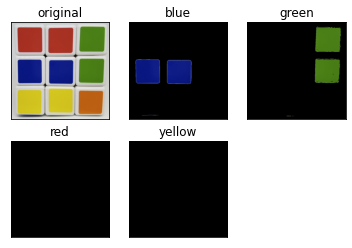

In [11]:
# p.146 hsv색상으로 마스킹
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 큐브 영상 hsv 변환
img = cv2.imread('./img/cube.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# 색상별 영역 지정
blue1 = np.array([90, 50, 50])
blue2 = np.array([120, 255, 255])
green1 = np.array([45, 50, 50])
green2 = np.array([75, 255, 255])
red1 = np.array([0, 50, 50])
red2 = np.array([15, 255, 255])
red3 = np.array([165, 50, 50])
red4 = np.array([180, 255, 255])
yellow1 = np.array([20, 50, 50])
yellow2 = np.array([35, 255, 25])

# 색상에 따른 마스크 생성
mask_blue = cv2.inRange(hsv, blue1, blue2)
mask_green = cv2.inRange(hsv, green1, green2)
mask_red = cv2.inRange(hsv, red1, red2)
mask_red2 = cv2.inRange(hsv, red3, red4)
mask_yellow = cv2.inRange(hsv, yellow1, yellow2)

# 마스크로 색상만 추출
res_blue = cv2.bitwise_and(img,img,mask=mask_blue)
res_green = cv2.bitwise_and(img,img,mask=mask_green)
res_red1 = cv2.bitwise_and(img,img,mask=mask_red)
res_red2 = cv2.bitwise_and(img,img,mask=mask_red2)
res_red = cv2.bitwise_and(res_red1, res_red2)
res_yellow = cv2.bitwise_and(img,img,mask=mask_yellow)

# 이미지 합성
imgs = {'original': img, 'blue': res_blue, 'green': res_green,
        'red': res_red, 'yellow': res_yellow}

for i, (k, v) in enumerate(imgs.items()):
    plt.subplot(2, 3, i+1)
    plt.title(k)
    plt.imshow(v[:, :, ::-1])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [13]:
# p.148 크로마키
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 읽기
img1 = cv2.imread('./img/man_chromakey.jpg')
img2 = cv2.imread('./img/street.jpg')


# ROI 선택을 위한 좌표 계산
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]
x = (width2 - width1)//2
y = (height2 - height1)
w = x + width1
h = y + height1

# 크로마키 배경 영상에 크로마키 있을 법한 영역을 10 픽셀 정도로 지정
chromakey = img1[:10, :10, :]
offset = 20

# 크로마키 영역과 전체 영상을 hsv로
hsv_chroma = cv2.cvtColor(chromakey, cv2.COLOR_BGR2HSV)
hsv_img = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)

# 크로마키 영역의 H값에서 offset 만큼 여유를 두어서 범위 지정
# offset 값은 여러차례 시도 후 결정
chroma_h = hsv_chroma[:, :, 0]
lower = np.array([chroma_h.min()-offset, 100, 100])
upper = np.array([chroma_h.max()+offset, 255, 255])

# 마스크 생성 및 마스킹 후 합성
mask = cv2.inRange(hsv_img, lower, upper)
mask_inv = cv2.bitwise_not(mask)
roi = img2[y:h, x:w]
fg = cv2.bitwise_and(img1, img1, mask=mask_inv)
bg = cv2.bitwise_and(roi, roi, mask=mask)
img2[y:h, x:w] = fg + bg

cv2.imshow('chromakey', img1)
cv2.imshow('added', img2)
cv2.waitKey()
cv2.destroyAllWindows()

In [14]:
# p.150 Seamless clone으로 합성
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 읽기
img1 = cv2.imread('./img/drawing.jpg')
img2 = cv2.imread('./img/my_hand.jpg')

# mask generate
mask = np.full_like(img1, 255)

# 합성 대상 좌표 계산
height, width = img2.shape[:2]
center = (width//2, height//2)

# seamlessClone으로 합성
normal = cv2.seamlessClone(img1, img2, mask, center, cv2.NORMAL_CLONE)
mixed = cv2.seamlessClone(img1, img2, mask, center, cv2.MIXED_CLONE)

cv2.imshow('normal', normal)
cv2.imshow('mixed', mixed)
cv2.waitKey()
cv2.destroyAllWindows() 

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 읽기
img1 = cv2.imread('./img/fish.jpg')
img2 = cv2.imread('./img/paper.jpg')

# mask generate
mask = np.full_like(img1, 255)

# 합성 대상 좌표 계산
height, width = img2.shape[:2]
lower = (width//2, height//4*3)

# seamlessClone으로 합성
normal = cv2.seamlessClone(img1, img2, mask, lower, cv2.NORMAL_CLONE)
mixed = cv2.seamlessClone(img1, img2, mask, lower, cv2.MIXED_CLONE)

cv2.imshow('normal', normal)
cv2.imshow('mixed', mixed)
cv2.waitKey()
cv2.destroyAllWindows() 

(256, 1)
270000.0 (450, 600)


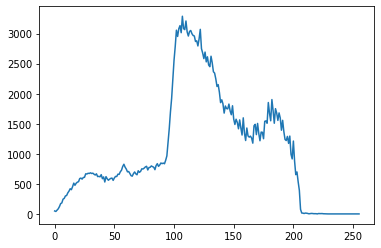

In [1]:
# p.153 histogram
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 읽기
img = cv2.imread('./img/mountain.jpg', cv2.IMREAD_GRAYSCALE)
cv2.imshow('img', img)
cv2.waitKey()
cv2.destroyAllWindows()

# hist 계산 및 그리기
hist = cv2.calcHist([img], [0], None, [256], [0, 256])
plt.plot(hist)

print(hist.shape)
print(hist.sum(), img.shape)
plt.show()

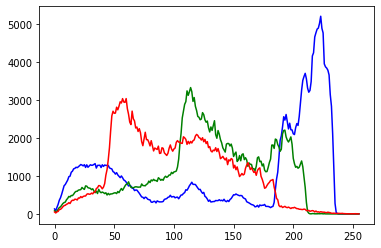

In [3]:
# p.154 color histogram
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 읽기
img = cv2.imread('./img/mountain.jpg')
cv2.imshow('img', img)
cv2.waitKey()
cv2.destroyAllWindows()

# hist 계산 및 그리기
channels = cv2.split(img)
colors = ('b', 'g', 'r')
for (ch, color) in zip (channels, colors):
    hist = cv2.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist, color=color)

plt.show()

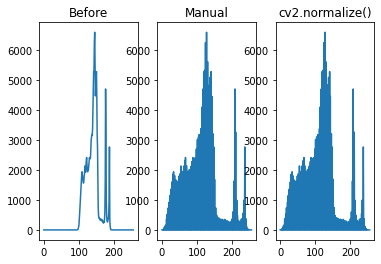

In [4]:
# p.156 histogram normalize
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 그레이 스케일로 이미지 읽기
img = cv2.imread('./img/abnormal.jpg', cv2.IMREAD_GRAYSCALE)

# 정규화
img_f = img.astype(np.float32)
img_norm = ((img_f - img_f.min())* (255) / (img_f.max() - img_f.min()))
img_norm = img_norm.astype(np.uint8)

# opencv API 정규화
img_norm2 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# histogram
hist = cv2.calcHist([img], [0], None, [256], [0, 255])
hist_norm = cv2.calcHist([img_norm], [0], None, [256], [0, 255])
hist_norm2 = cv2.calcHist([img_norm2], [0], None, [256], [0, 255])

cv2.imshow('Before', img)
cv2.imshow('Manual', img_norm)
cv2.imshow('cv2.normalize', img_norm2)
cv2.waitKey()
cv2.destroyAllWindows()

# hist 계산 및 그리기
hist = {'Before': hist, 'Manual': hist_norm, 'cv2.normalize()': hist_norm2}
for i, (k, v) in enumerate(hist.items()):
    plt.subplot(1, 3, i+1)
    plt.title(k)
    plt.plot(v)

plt.show()

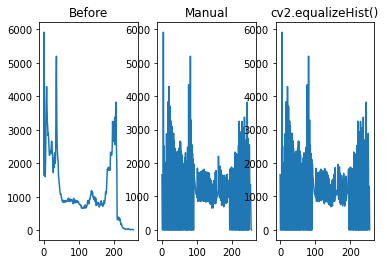

In [6]:
# p.159 histogram equalizer
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 그레이 스케일로 이미지 읽기
img = cv2.imread('./img/yate.jpg', cv2.IMREAD_GRAYSCALE)
rows, cols = img.shape[:2]

# equalize
hist = cv2.calcHist([img], [0], None, [256], [0, 256])
cdf = hist.cumsum()
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m-cdf_m.min()) / (rows*cols)*255
cdf = np.ma.filled(cdf_m, 0).astype('uint8')
img2 = cdf[img]

# opencv API 정규화
img3 = cv2.equalizeHist(img)

# histogram
hist2 = cv2.calcHist([img2], [0], None, [256], [0, 255])
hist3 = cv2.calcHist([img3], [0], None, [256], [0, 255])

# 결과
cv2.imshow('Before', img)
cv2.imshow('Manual', img2)
cv2.imshow('cv2.equalizeHist()', img3)
cv2.waitKey()
cv2.destroyAllWindows()

# hist 계산 및 그리기
hist = {'Before': hist, 'Manual': hist2, 'cv2.equalizeHist()': hist3}
for i, (k, v) in enumerate(hist.items()):
    plt.subplot(1, 3, i+1)
    plt.title(k)
    plt.plot(v)

plt.show()

In [9]:
# p.160 color histogram equalizer
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 그레이 스케일로 이미지 읽기
img = cv2.imread('./img/yate.jpg')
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

# equalize
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:, :, 0])

img2 = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

# 결과
cv2.imshow('Before', img)
cv2.imshow('After', img2)
cv2.waitKey()
cv2.destroyAllWindows()